# Plot the multiscale basis in 1D

Evaluates the correction $\phi_x := \mathcal{Q}\lambda_x \in V^f$ for all $x\in \mathcal{N}_H$ and plots the correction, as well as the multiscale basis $\lambda_x - \phi_x$.

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from gridlod import util, fem, coef, interp, linalg
from gridlod.world import World
import lod_wave

'''
Settings
'''

# fine mesh parameters
fine = 256
NFine = np.array([fine])
NpFine = np.prod(NFine+1)
boundaryConditions = np.array([[0, 0]])
world = World(np.array([256]), NFine/np.array([256]), boundaryConditions)
NWorldFine = world.NWorldCoarse * world.NCoarseElement

# fine grid elements and nodes
xt = util.tCoordinates(NFine).flatten()
xp = util.pCoordinates(NFine).flatten()
tau = 0.01

# ms coefficients
epsA = 2 ** (-5)
epsB = 2 ** (-5)
aFine = (2 - np.sin(2 * np.pi * xt / epsA)) ** (-1)
bFine = (2 - np.cos(2 * np.pi * xt / epsB)) ** (-1)

k_0 = np.inf
N = 8

# coarse mesh parameters
NWorldCoarse = np.array([N])
NCoarseElement = NFine / NWorldCoarse
world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

# grid nodes
xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
NpCoarse = np.prod(NWorldCoarse + 1)

'''
Compute multiscale basis
'''

# patch generator and coefficients
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse,
                                                              NCoarseElement, boundaryConditions)
b_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, bFine)
a_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, aFine / tau)

# compute basis correctors
lod = lod_wave.LodWave(b_coef, world, k_0, IPatchGenerator, a_coef)
lod.compute_basis_correctors()

# compute ms basis
basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
basis_correctors = lod.assembleBasisCorrectors()
ms_basis = basis - basis_correctors

# Plot the basis correction

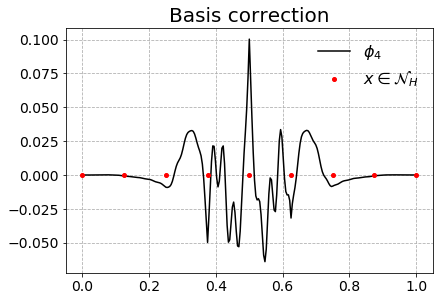

In [3]:
x = N/2
plt.figure('Basis corr')
plt.subplots_adjust(left=0.14, bottom=0.07, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=14)
plt.plot(xp, basis_correctors[:,x].todense(), 'k', label='$\phi_{%d}$' %(x), linewidth=1.5)
plt.plot(xpCoarse, 0 * xpCoarse, 'or', label='$x\in \mathcal{N}_H$', markersize=4)
plt.title('Basis correction', fontsize=20)
plt.grid(True, which="both", ls="--")
plt.legend(frameon=False, fontsize=16)
plt.show()

# Plot the multiscale basis

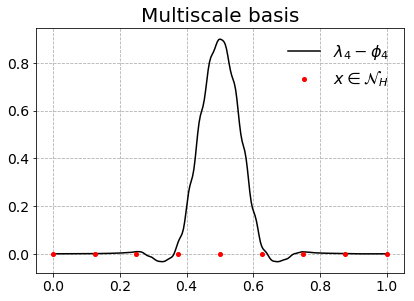

In [4]:
x = N/2
plt.figure('Ms basis')
plt.subplots_adjust(left=0.14, bottom=0.07, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=14)
plt.plot(xp, ms_basis[:,x].todense(), 'k', label='$\lambda_{%d} - \phi_{%d}$' %(x, x), linewidth=1.5)
plt.plot(xpCoarse, 0 * xpCoarse, 'or', label='$x\in \mathcal{N}_H$', markersize=4)
plt.title('Multiscale basis', fontsize=20)
plt.grid(True, which="both", ls="--")
plt.legend(frameon=False, fontsize=16)
plt.show()